# Survival Analysis

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [65]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalWeibullCdf, MakeBinomialPmf, MakeMixture
import thinkplot

from itertools import product

## The Weibull distribution

The Weibull distribution is often used in survival analysis because it models the distribution of lifetimes for manufactured products, at least over some parts of the range.

The following functions evaluate its PDF and CDF.

In [2]:
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

SciPy also provides functions to evaluate the Weibull distribution, which I'll use to check my implementation.

In [3]:
from scipy.stats import weibull_min

lam = 2
k = 1.5
x = 0.5

weibull_min.pdf(x, k, scale=lam)

0.33093633846922332

In [4]:
EvalWeibullPdf(x, lam, k)

0.33093633846922332

In [5]:
weibull_min.cdf(x, k, scale=lam)

0.1175030974154046

In [6]:
EvalWeibullCdf(x, lam, k)

0.11750309741540454

And here's what the PDF looks like, for these parameters.

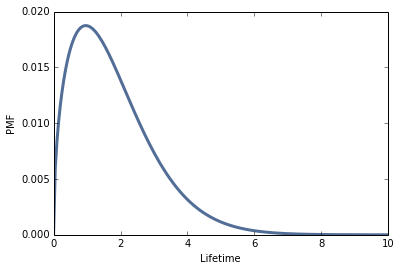

In [7]:
pmf = MakeWeibullPmf(lam, k, high=10)
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Lifetime',
                 ylabel='PMF')

We can use np.random.weibull to generate random values from a Weibull distribution with given parameters.

To check that it is correct, I generate a large sample and compare its CDF to the analytic CDF.

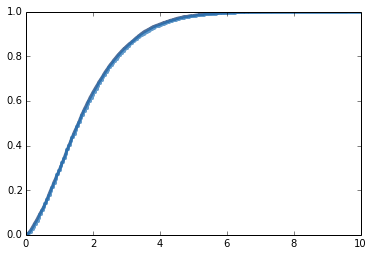

In [8]:
def SampleWeibull(lam, k, n=1):
    return np.random.weibull(k, size=n) * lam

data = SampleWeibull(lam, k, 10000)
cdf = Cdf(data)
model = pmf.MakeCdf()
thinkplot.Cdfs([cdf, model])

**Exercise:** Write a class called `LightBulb` that inherits from `Suite` and `Joint` and provides a `Likelihood` function that takes an observed lifespan as data and a tuple, `(lam, k)`, as a hypothesis.  It should return a likelihood proportional to the probability of the observed lifespan in a Weibull distribution with the given parameters.

Test your method by creating a `LightBulb` object with an appropriate prior and update it with a random sample from a Weibull distribution.

Plot the posterior distributions of `lam` and `k`.  As the sample size increases, does the posterior distribution converge on the values of `lam` and `k` used to generate the sample?

In [9]:
class Lightbulb(Suite, Joint):
    def Likelihood(self, data, hypo):
        x = data
        lam, k = hypo
        if (lam == 0):
            return 0
        like = EvalWeibullCdf(x, lam, k)
        return like

In [10]:
lmbs = np.linspace(0, 5, 100)
ks = np.linspace(0, 5, 100)
light = Lightbulb(product(lmbs, ks))

In [11]:
light.Update(1)

0.32647439671381523

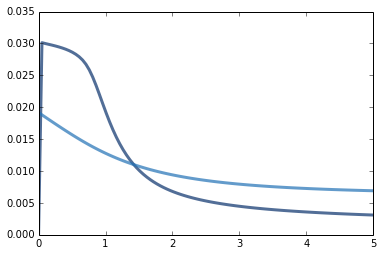

In [12]:
thinkplot.Pdf(light.Marginal(0))
thinkplot.Pdf(light.Marginal(1))

In [13]:
# Solution goes here

In [14]:
# Solution goes here

**Exercise:** Now suppose that instead of observing a lifespan, `k`, you observe a lightbulb that has operated for 1 year and is still working.  Write another version of `LightBulb` that takes data in this form and performs an update. 

In [15]:
class Lightbulb(Suite, Joint):
    def Likelihood(self, data, hypo):
        x = data
        lam, k = hypo
        like = EvalWeibullCdf(x, lam, k)
        return like

In [16]:
# Solution goes here

In [17]:
# Solution goes here

In [18]:
# Solution goes here

In [19]:
# Solution goes here

**Exercise:** Now let's put it all together.  Suppose you have 15 lightbulbs installed at different times over a 10 year period.  When you observe them, some have died and some are still working.  Write a version of `LightBulb` that takes data in the form of a `(flag, x)` tuple, where:

1. If `flag` is `eq`, it means that `x` is the actual lifespan of a bulb that has died.
2. If `flag` is `gt`, it means that `x` is the current age of a bulb that is still working, so it is a lower bound on the lifespan.

To help you test, I will generate some fake data.

First, I'll generate a Pandas DataFrame with random start times and lifespans.  The columns are:

`start`: time when the bulb was installed

`lifespan`: lifespan of the bulb in years

`end`: time when bulb died or will die

`age_t`: age of the bulb at t=10

In [20]:
import pandas as pd

lam = 2
k = 1.5
n = 15
t_end = 10
starts = np.random.uniform(0, t_end, n)
lifespans = SampleWeibull(lam, k, n)

df = pd.DataFrame({'start': starts, 'lifespan': lifespans})
df['end'] = df.start + df.lifespan
df['age_t'] = t_end - df.start

df.head()

,lifespan,start,end,age_t
0,2.614261,0.635954,3.250215,9.364046
1,4.604399,1.085165,5.689564,8.914835
2,0.980352,7.527410,8.507762,2.472590
3,0.716525,4.916123,5.632648,5.083877
4,0.080597,3.583381,3.663978,6.416619


Now I'll process the DataFrame to generate data in the form we want for the update.

In [21]:
data = []
for i, row in df.iterrows():
    if row.end < t_end:
        data.append(('eq', row.lifespan))
    else:
        data.append(('gt', row.age_t))
        
for pair in data:
    print(pair)

('eq', 2.6142610530431085)
('eq', 4.6043994372015424)
('eq', 0.98035216122765878)
('eq', 0.71652510303483552)
('eq', 0.080597479370532937)
('eq', 0.8377815629707136)
('gt', 1.8621584610348929)
('eq', 1.7290682881583739)
('eq', 1.075380409972315)
('eq', 2.1453265051316261)
('gt', 2.6978370986608979)
('eq', 1.3817609038021119)
('eq', 2.5123912433276399)
('eq', 2.5174695116731898)
('eq', 0.51488442788673117)


In [22]:
class Lightbulb(Suite, Joint):
    def Likelihood(self, data, hypo):
        flag, x = data
        lam, k = hypo
        if lam == 0:
            return 0
        if (flag == 'eq'):
            like = EvalWeibullPdf(x, lam, k)
        elif flag == 'gt':
            like = 1 - EvalWeibullCdf(x, lam, k)
        return like

In [23]:
lmbs = np.linspace(0, 5, 100)
ks = np.linspace(0, 5, 100)
light = Lightbulb(product(lmbs, ks))

In [24]:
light.UpdateSet(data)

2.3115916129396982e-11

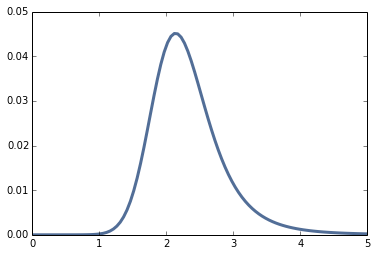

In [25]:
thinkplot.Pdf(light.Marginal(0))

In [26]:
# Solution goes here

**Exercise:** Suppose you install a light bulb and then you don't check on it for a year, but when you come back, you find that it has burned out.  Extend `LightBulb` to handle this kind of data, too.

In [27]:
class Lightbulb(Suite, Joint):
    def Likelihood(self, data, hypo):
        flag, x = data
        lam, k = hypo
        if lam == 0:
            return 0
        if (flag == 'eq'):
            like = EvalWeibullPdf(x, lam, k)
        elif flag == 'gt':
            like = 1 - EvalWeibullCdf(x, lam, k)
        elif flag == 'lt':
            like = EvalWeibullCdf(x, lam, k)
        return like

## Prediction

**Exercise:** Suppose we know that, for a particular kind of lightbulb in a particular location, the distribution of lifespans is well modeled by a Weibull distribution with `lam=2` and `k=1.5`.  If we install `n=100` lightbulbs and come back one year later, what is the distribution of `c`, the number of lightbulbs that have burned out?

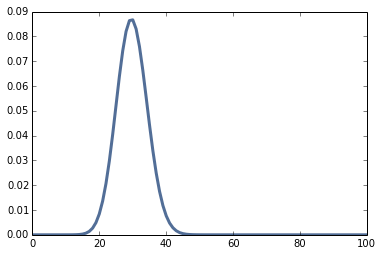

In [62]:
burnedOut = MakeBinomialPmf(100, EvalWeibullCdf(1, 2, 1.5))

thinkplot.Pdf(burnedOut)

In [56]:
# Solution goes here

**Exercise:** Now suppose that `lam` and `k` are not known precisely, but we have a `LightBulb` object that represents the joint posterior distribution of the parameters after seeing some data.  Compute the posterior predictive distribution for `c`, the number of bulbs burned out after one year.

In [54]:
pmf = Joint(product(np.linspace(0, 10, 10), np.linspace(0, 10, 10)))

In [66]:
metaPmf = Pmf()
for hypo, prob in light.Items():
    lam, k = hypo
    pmf = MakeWeibullPmf(lam, k, 10)
    metaPmf.Set(pmf, prob)
mix = MakeMixture(metaPmf)

In [ ]:
p = Pmf(['w', 'l'])
